In [4]:
# Wavefunction generation
from pyscf import mcscf, fci, lib 
from pyscf import gto, scf, tools, dft
import api as pyq 
import importlib
import os
import h5py
import pandas as pd
import pdb
import pyscf
import numpy as np
import pyqmc
import scipy
import matplotlib.pyplot as plt
from pyscf.scf.hf import dump_scf_summary
from concurrent.futures import ProcessPoolExecutor
from pyscf.scf.chkfile import dump_scf
print(pyq.__file__)
print(pyscf.__file__)

/Users/ksu/Documents/GitHub/pyqmc/pyqmc/api.py
/Users/ksu/Software/anaconda3/lib/python3.11/site-packages/pyscf/__init__.py


In [5]:
# H2 molecule
def run_scf(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.;H 0. 0. 1.;", basis=f'ccecpccpvdz', unit='bohr')
    mf = scf.UHF(mol)
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm)
    dump_scf(mf.mol, 'scf.hdf5', mf.energy_tot(), mf.mo_energy, mf.mo_coeff, mf.mo_occ)
    return mf

def run_lda_be(scf_checkfile):
    print("Be atom neutral LDA spin=2")
    mol = gto.M(atom="Be 0. 0. 0.", spin=2,basis=f'ccpvdz', unit='bohr')
    print("HF")
    mf = scf.UHF(mol)
    mf.kernel()
    print("LDA")        
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf

def run_lda_li(scf_checkfile):
    print("Li atom neutral LDA spin=1")
    mol = gto.M(atom="Li 0. 0. 0.",basis=f'ccpvtz', spin=1, unit='bohr')
    print("HF")
    mf = scf.UHF(mol)
    mf.kernel()
    print("LDA")    
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf

def run_lda_he(scf_checkfile):
    print("He atom neutral LDA spin=0")
    # mol = gto.M(atom="He 0. 0. 0.", basis="ccECP_cc-pVDZ", ecp="ccecp", unit='bohr')
    mol = gto.M(atom="He 0. 0. 0.", basis="ccpvdz", unit='bohr')    
    print("HF")
    mf = scf.UHF(mol)
    mf.kernel()
    print("LDA")    
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf

def run_lda_h2(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.; H 0. 0. 2", spin = 2, basis=f'ccecpccpvdz', unit='bohr')
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.xc='LDA, VWN'
    mf.kernel()    
    # mf.kernel(dm, xc='LDA,VWN')
    return mf

def run_lda(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.", spin=1,basis=f'ccecpccpvdz', unit='bohr')
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf
    
def run_casscf(scf_checkfile, ci_checkfile):
    cell, mf = pyq.recover_pyscf(scf_checkfile, cancel_outputs=False)
    mc = mcscf.CASSCF(mf,2,2)
    mc.chkfile = ci_checkfile
    mc.kernel()
    with h5py.File(mc.chkfile, "a") as f:
        print("Available output from CASSCF:", f["mcscf"].keys())
        f["mcscf/nelecas"] = list(mc.nelecas)
        f["mcscf/ci"] = mc.ci
    return mc

def run_casci(scf_checkfile, ci_checkfile):
    cell, mf = pyq.recover_pyscf(scf_checkfile, cancel_outputs=False)
    # ncas: orbitals
    # nelecas: electrons
    ncas = 4
    nelecas = 2
    mc = mcscf.CASCI(mf, ncas, nelecas)
    mc.kernel()
    print(mc.__dict__.keys())
    with h5py.File(ci_checkfile, "a") as f:
        f.create_group("ci")
        f["ci/ncas"] = mc.ncas
        f["ci/nelecas"] = list(mc.nelecas)
        f["ci/ci"] = mc.ci
        f["ci/mo_coeff"] = mc.mo_coeff
        print("Available output from CASCI:", f["ci"].keys())
    return mc

def make_wf_object(scf_checkfile, ci_checkfile):
    mol, mf, mc = pyq.recover_pyscf(scf_checkfile, ci_checkfile=ci_checkfile)
    wf, _ = pyq.generate_wf(mol, mf, mc=mc)
    return wf

def stat_qmc(etot, filename):
    block_sizes = np.linspace(2,len(etot[discard:])//16, 10, dtype=int)
    reblocks = [len(etot)//s for s in block_sizes]

    plt.figure()
    df = pd.DataFrame([pyq.read_mc_output(filename, warmup=discard, reblock=reblock) for reblock in reblocks])
    df['block_size'] = block_sizes
    plt.plot("block_size",'energytotal_err',data=df, marker='o')
    plt.xlabel("Block size")
    plt.ylabel("Estimated uncertainty (Ha)")

def reblock(e, discard, reblock_size):
    e = e[discard:]
    vals = pyqmc.reblock.reblock(e,int(len(e)/reblock_size))
    # import pdb
    # pdb.set_trace()
    
    e_m  = np.mean(vals, axis=0)
    e_d  = scipy.stats.sem(vals, axis=0)    
    return e, e_m, e_d

scf_checkfile = "scf.hdf5"
ci_checkfile = "ci.hdf5"
# mf = run_scf(scf_checkfile)
mf_lda = run_lda_he(scf_checkfile)

# mc = run_casci(scf_checkfile, ci_checkfile)

He atom neutral LDA spin=0
HF
converged SCF energy = -2.85516047724274  <S^2> = 0  2S+1 = 1
LDA
converged SCF energy = -2.82670655418611  <S^2> = 4.4408921e-16  2S+1 = 1


In [12]:
from recipes import ABOPTIMIZE, OPTIMIZE
import importlib, recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf
modules = [recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)
    # Jastrow optimizationn
    
for fname in ['sj.hdf5']:
    if os.path.isfile(fname):
        os.remove(fname)
print("RUNNING VMC OPTIMIZATION")
# pyq.OPTIMIZE(scf_checkfile, "sj.hdf5", ci_checkfile=ci_checkfile, max_iterations=2, verbose=False)
pyq.OPTIMIZE(scf_checkfile, "sj.hdf5", max_iterations=4, nconfig=200, verbose=True)

# Jastrow optimization results
df = pyq.read_opt("sj.hdf5")
df

RUNNING VMC OPTIMIZATION
starting warmup
finished warmup
it 0 ====================
x0 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
----------vmc done
en -2.7068619617672676 en_err 0.012368220573313262
pgrad [0.03784674 0.02469143 0.12576368 0.08987108 0.2738082  0.21372096
 0.37642571 0.30306799 0.         0.10093319 0.         0.
 0.22008333 0.         0.         0.24471623 0.        ]
descent en -2.7068619617672676 0.012368220573313262  estimated sigma  1.7491305277201556
descent |grad| 0.706144231039929
params [array([-0.01201784, -0.01329361, -0.00818615, -0.01286371,  0.05529524,
        0.04374884,  0.15210434,  0.12761182,  0.        , -0.00254305,
        0.        ,  0.        ,  0.03298656,  0.        ,  0.        ,
        0.0689924 ,  0.        ]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([ 0.01201784,  0.01329361,  0.00818615,  0.01286371, -0.05529524,
       -0.04374884, -0.15210434, -0.12761182,  0.        ,  0.00254305,


,energy,iteration,error,fname
0,-2.706862,0,0.012368,sj.hdf5
1,-2.888105,1,0.012985,sj.hdf5
2,-2.893310,2,0.015131,sj.hdf5
3,-2.886346,3,0.006422,sj.hdf5


In [6]:
tstep = 0.001
nconfig = 2000
nsteps = 1000
discard = 100
reblock_size = 50

In [18]:
import importlib, recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf
modules = [recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)
import pyqmc.pyscftools as pyscftools
from accumulators import ABQMCEnergyAccumulator

def initialize_boson_qmc_objects_j(
    dft_checkfile,
):  
    mol, mf = pyscftools.recover_pyscf(scf_checkfile)
    wf, to_opt = wftools.generate_boson_wf(
        mol, mf, jastrow = None
    )
    load_parameters = 'sj.hdf5'
    wftools.read_wf(wf, load_parameters)      
    return wf

def initialize_qmc_objects_j(
    dft_checkfile: str,
):
    mol, mf = pyscftools.recover_pyscf(dft_checkfile)
    wf, to_opt = wftools.generate_wf(
        mol, mf, jastrow=None
    )
    load_parameters = 'sj.hdf5'
    wftools.read_wf(wf, load_parameters)      
    return wf

In [19]:
trials = 100
for i in range(trials):
    nconfig = 100
    mol, mf = pyscftools.recover_pyscf(scf_checkfile)
    configs = mc.initial_guess(mol, nconfig, seed = i)
    # wfb = initialize_boson_qmc_objects_j(
    #     scf_checkfile,
    # )
    wf = initialize_qmc_objects_j(
            scf_checkfile,
        )
    e=0
    sign, phi1 = wf.recompute(configs)
    g1, phi, saved1 = wf.gradient_value(e, configs.electron(e))  
    # phi1a = saved['phi']
    e=0
    signb, phi2 = wfb.recompute(configs)
    g1b, saved2 = wfb.gradient_value(e, configs.electron(e))
    phi2a = saved2['psi']
    
    plt.scatter(np.exp(phi1), phi2)
x = np.linspace(0, 0.7, 100)
plt.plot(x,x)
plt.xlabel('Bosonic no jastrow')
plt.ylabel('Fermionic no jastrow')
plt.title(str(trials) + ' trials')

> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/wftools.py(198)read_wf()
    196             import pdb
    197             pdb.set_trace()
--> 198             if wf.parameters[k].shape != new_parms.shape:
    199                 raise Exception(
    200                     f"For wave function parameter {k}, shape in {wf_file} is {new_parms.shape}, while current shape is {wf.parameters[k].shape}"



ipdb>  new_parms


array([[[ 2.        ,  2.        ],
        [ 0.02708838,  0.03203636],
        [ 0.04066223,  0.03766081],
        [-0.03710231, -0.0751232 ],
        [-0.20613607, -0.2528293 ]]])


ipdb>  wf.parameters


[{'det_coeff': array([1.])}, {'mo_coeff_alpha': array([[ 5.76470293e-01],
       [ 5.29591463e-01],
       [ 3.96329422e-18],
       [ 2.53688511e-17],
       [-1.08068490e-17]]), 'mo_coeff_beta': array([[ 5.76470293e-01],
       [ 5.29591463e-01],
       [ 3.96329422e-18],
       [ 2.53688511e-17],
       [-1.08068490e-17]])}]


ipdb>  n


TypeError: list indices must be integers or slices, not NoneType
> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/wftools.py(198)read_wf()
    196             import pdb
    197             pdb.set_trace()
--> 198             if wf.parameters[k].shape != new_parms.shape:
    199                 raise Exception(
    200                     f"For wave function parameter {k}, shape in {wf_file} is {new_parms.shape}, while current shape is {wf.parameters[k].shape}"



ipdb>  exit


In [17]:
trials = 100
for i in range(trials):
    nconfig = 100
    mol, mf = pyscftools.recover_pyscf(scf_checkfile)
    configs = mc.initial_guess(mol, nconfig, seed = i)
    wfb = initialize_boson_qmc_objects(
        scf_checkfile,
    )
    wf = initialize_qmc_objects(
            scf_checkfile,
        )
    e=0
    sign, val = wf.recompute(configs)
    g1, val2, (aograd, mograd) = wf.gradient_value(e, configs.electron(e))  
    e=0
    signb, valb = wfb.recompute(configs)
    g1b, saved = wfb.gradient_value(e, configs.electron(e))
    valb2 = saved['psi']
    plt.scatter(np.exp(val), valb)
x = np.linspace(0, 0.7, 100)
plt.plot(x,x)
plt.xlabel('Grad bosonic no jastrow')
plt.ylabel('Grad fermionic no jastrow')
plt.title(str(trials) + ' configurations')

Number of determinants in the bosonic wavefunction= 1


TypeError: list indices must be integers or slices, not NoneType

Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in th

Text(0.5, 1.0, '100 configurations')

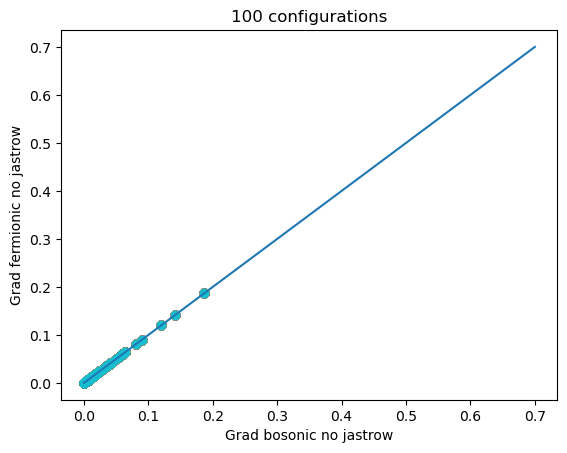

In [28]:
trials = 100
for i in range(trials):
    nconfig = 100
    mol, mf = pyscftools.recover_pyscf(scf_checkfile)
    configs = mc.initial_guess(mol, nconfig, seed = 1100)
    wfb = initialize_boson_qmc_objects(
        scf_checkfile,
    )
    wf = initialize_qmc_objects(
            scf_checkfile,
        )
    e=0
    sign, val = wf.recompute(configs)
    g1, val2, (aograd, mograd) = wf.gradient_value(e, configs.electron(e))  
    e=0
    signb, valb = wfb.recompute(configs)
    g1b, saved = wfb.gradient_value(e, configs.electron(e))
    valb = saved['psi']
    plt.scatter(np.exp(val), valb)
x = np.linspace(0, 0.7, 100)
plt.plot(x,x)
plt.xlabel('Grad bosonic no jastrow')
plt.ylabel('Grad fermionic no jastrow')
plt.title(str(trials) + ' configurations')